<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#load-data" data-toc-modified-id="load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load data</a></span><ul class="toc-item"><li><span><a href="#read-in-the-files" data-toc-modified-id="read-in-the-files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>read in the files</a></span><ul class="toc-item"><li><span><a href="#data-from-linear-and-relu-activations" data-toc-modified-id="data-from-linear-and-relu-activations-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>data from linear and relu activations</a></span></li></ul></li><li><span><a href="#create-pandas-table" data-toc-modified-id="create-pandas-table-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>create pandas table</a></span></li></ul></li><li><span><a href="#filter-out-bad-training-losses" data-toc-modified-id="filter-out-bad-training-losses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>filter out bad training losses</a></span></li><li><span><a href="#determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)" data-toc-modified-id="determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>determine the lambda parameter that gets the best test MSE for each (r,n,L)</a></span></li><li><span><a href="#Generalization-MSE" data-toc-modified-id="Generalization-MSE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generalization MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Out-of-Distribution-MSE" data-toc-modified-id="Out-of-Distribution-MSE-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Out of Distribution MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Active-Subspace" data-toc-modified-id="Active-Subspace-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Active Subspace</a></span><ul class="toc-item"><li><span><a href="#evaluate-gradients-and-compute-singular-values-and-active-subspaces" data-toc-modified-id="evaluate-gradients-and-compute-singular-values-and-active-subspaces-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>evaluate gradients and compute singular values and active subspaces</a></span></li><li><span><a href="#plot-of-singular-values" data-toc-modified-id="plot-of-singular-values-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>plot of singular values</a></span></li></ul></li><li><span><a href="#determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)" data-toc-modified-id="determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>determine the L parameter that gets the best test MSE for each (r,n)</a></span></li><li><span><a href="#Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers" data-toc-modified-id="Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plots of L vs Test error and n vs Generalization metrics with/without linear layers</a></span></li><li><span><a href="#Final-Table" data-toc-modified-id="Final-Table-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Final Table</a></span></li><li><span><a href="#Training-Time-Plots" data-toc-modified-id="Training-Time-Plots-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Training Time Plots</a></span><ul class="toc-item"><li><span><a href="#Train-MSE-v-Epoch" data-toc-modified-id="Train-MSE-v-Epoch-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Train MSE v Epoch</a></span></li><li><span><a href="#Weight-Decay-v-Epoch" data-toc-modified-id="Weight-Decay-v-Epoch-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Weight Decay v Epoch</a></span></li><li><span><a href="#learning-rates" data-toc-modified-id="learning-rates-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>learning rates</a></span></li></ul></li></ul></div>

# imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import ortho_group
from scipy.stats import linregress
from scipy import linalg as la
from torch import nn
import torch
import os

# load data

## read in the files

In [2]:
rnvals = [(1,64),(1,128),(1,256),(1,512),(1,1024),(1,2048),
          (2,64),(2,128),(2,256),(2,512),(2,1024),(2,2048)]
Ls = [2,3,4,5,6,7,8,9]
wds = [1e-3,1e-4,1e-5]
epochs = 60100
job_name = "GPUlabelnoise"#"GPUmanylayers"

### data from linear and relu activations

In [3]:
testMSEs = {}
trainMSEs = {}
weightdecays = {}
learningrates = {}
files_found_list = []
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            paramname = job_name+f"/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
            if os.path.exists(paramname+"testMSE.npy"):
                testMSEs[r,n,L,wd] = np.load(paramname+"testMSE.npy",allow_pickle=True).item()
                trainMSEs[r,n,L,wd] = np.load(paramname+"trainMSEs.npy",allow_pickle=True)
                weightdecays[r,n,L,wd] = np.load(paramname+"weightdecays.npy",allow_pickle=True)
                learningrates[r,n,L,wd] = np.load(paramname+"learningrates.npy",allow_pickle=True)
                files_found_list.append((r,n,L,wd))
            else:
                print(f"{paramname+'testMSE.npy'} not found")

In [4]:
files_found_list

[(1, 64, 2, 0.001),
 (1, 64, 2, 0.0001),
 (1, 64, 2, 1e-05),
 (1, 64, 3, 0.001),
 (1, 64, 3, 0.0001),
 (1, 64, 3, 1e-05),
 (1, 64, 4, 0.001),
 (1, 64, 4, 0.0001),
 (1, 64, 4, 1e-05),
 (1, 64, 5, 0.001),
 (1, 64, 5, 0.0001),
 (1, 64, 5, 1e-05),
 (1, 64, 6, 0.001),
 (1, 64, 6, 0.0001),
 (1, 64, 6, 1e-05),
 (1, 64, 7, 0.001),
 (1, 64, 7, 0.0001),
 (1, 64, 7, 1e-05),
 (1, 64, 8, 0.001),
 (1, 64, 8, 0.0001),
 (1, 64, 8, 1e-05),
 (1, 64, 9, 0.001),
 (1, 64, 9, 0.0001),
 (1, 64, 9, 1e-05),
 (1, 128, 2, 0.001),
 (1, 128, 2, 0.0001),
 (1, 128, 2, 1e-05),
 (1, 128, 3, 0.001),
 (1, 128, 3, 0.0001),
 (1, 128, 3, 1e-05),
 (1, 128, 4, 0.001),
 (1, 128, 4, 0.0001),
 (1, 128, 4, 1e-05),
 (1, 128, 5, 0.001),
 (1, 128, 5, 0.0001),
 (1, 128, 5, 1e-05),
 (1, 128, 6, 0.001),
 (1, 128, 6, 0.0001),
 (1, 128, 6, 1e-05),
 (1, 128, 7, 0.001),
 (1, 128, 7, 0.0001),
 (1, 128, 7, 1e-05),
 (1, 128, 8, 0.001),
 (1, 128, 8, 0.0001),
 (1, 128, 8, 1e-05),
 (1, 128, 9, 0.001),
 (1, 128, 9, 0.0001),
 (1, 128, 9, 1e-05),


In [5]:
def Llayers(L,d=20,width=1000):
    #construct L-1 linear layers; bias term only on last linear layer
    if L < 2:
        raise ValueError("L must be at least 2")
    if L == 2:
        linear_layers = [nn.Linear(d,width,bias=True)]
    if L > 2:
        linear_layers = [nn.Linear(d,width,bias=False)]
        for l in range(L-3):
            linear_layers.append(nn.Linear(width,width,bias=False))
        linear_layers.append(nn.Linear(width,width,bias=True))

    relu = nn.ReLU()

    last_layer = nn.Linear(width,1)

    layers = linear_layers + [relu,last_layer]

    return nn.Sequential(*layers)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
ls GPUlabelnoise_moreepochs/N64_L2_r*.pt

GPUlabelnoise_moreepochs/N64_L2_r1_wd0.0001_epochs100100model.pt
GPUlabelnoise_moreepochs/N64_L2_r1_wd0.001_epochs100100model.pt
GPUlabelnoise_moreepochs/N64_L2_r1_wd1e-05_epochs100100model.pt
GPUlabelnoise_moreepochs/N64_L2_r2_wd0.0001_epochs100100model.pt
GPUlabelnoise_moreepochs/N64_L2_r2_wd0.001_epochs100100model.pt
GPUlabelnoise_moreepochs/N64_L2_r2_wd1e-05_epochs100100model.pt


In [8]:
files_found_list = []
models = {}
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            paramname = job_name+f"/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
            if os.path.exists(paramname+"model.pt"):
                models[r,n,L,wd] = Llayers(L,width=1000)
                models[r,n,L,wd].to(device)
                if torch.cuda.is_available():
                    models[r,n,L,wd].load_state_dict(torch.load(paramname+"model.pt"))
                else:
                    models[r,n,L,wd].load_state_dict(torch.load(paramname+"model.pt"),map_location=torch.device('cpu'))
                models[r,n,L,wd].eval()
                files_found_list.append((r,n,L,wd))
            else:
                print(paramname+"model.pt","not found")

In [9]:
files_found_list

[(1, 64, 2, 0.001),
 (1, 64, 2, 0.0001),
 (1, 64, 2, 1e-05),
 (1, 64, 3, 0.001),
 (1, 64, 3, 0.0001),
 (1, 64, 3, 1e-05),
 (1, 64, 4, 0.001),
 (1, 64, 4, 0.0001),
 (1, 64, 4, 1e-05),
 (1, 64, 5, 0.001),
 (1, 64, 5, 0.0001),
 (1, 64, 5, 1e-05),
 (1, 64, 6, 0.001),
 (1, 64, 6, 0.0001),
 (1, 64, 6, 1e-05),
 (1, 64, 7, 0.001),
 (1, 64, 7, 0.0001),
 (1, 64, 7, 1e-05),
 (1, 64, 8, 0.001),
 (1, 64, 8, 0.0001),
 (1, 64, 8, 1e-05),
 (1, 64, 9, 0.001),
 (1, 64, 9, 0.0001),
 (1, 64, 9, 1e-05),
 (1, 128, 2, 0.001),
 (1, 128, 2, 0.0001),
 (1, 128, 2, 1e-05),
 (1, 128, 3, 0.001),
 (1, 128, 3, 0.0001),
 (1, 128, 3, 1e-05),
 (1, 128, 4, 0.001),
 (1, 128, 4, 0.0001),
 (1, 128, 4, 1e-05),
 (1, 128, 5, 0.001),
 (1, 128, 5, 0.0001),
 (1, 128, 5, 1e-05),
 (1, 128, 6, 0.001),
 (1, 128, 6, 0.0001),
 (1, 128, 6, 1e-05),
 (1, 128, 7, 0.001),
 (1, 128, 7, 0.0001),
 (1, 128, 7, 1e-05),
 (1, 128, 8, 0.001),
 (1, 128, 8, 0.0001),
 (1, 128, 8, 1e-05),
 (1, 128, 9, 0.001),
 (1, 128, 9, 0.0001),
 (1, 128, 9, 1e-05),


## create pandas table

In [10]:
res = {
  "r"                 : [r                         for r,n,L,wd in files_found_list],# + [r                         for wd in wds for r,n in relu_rnvals],
  "n"                 : [n                         for r,n,L,wd in files_found_list],# + [n                         for wd in wds for r,n in relu_rnvals],
  "L"                 : [L                         for r,n,L,wd in files_found_list],# + [4                         for wd in wds for r,n in relu_rnvals],
  "lambda"            : [wd                        for r,n,L,wd in files_found_list],# + [wd                        for wd in wds for r,n in relu_rnvals],
  "Learning Rate"     : [learningrates[r,n,L,wd]   for r,n,L,wd in files_found_list],# + [RELUlearningrates[r,n][4][wd] for wd in wds for r,n in relu_rnvals],
  "Train MSE"         : [trainMSEs[r,n,L,wd]       for r,n,L,wd in files_found_list],# + [RELUtrainMSEs[r,n][4][wd]     for wd in wds for r,n in relu_rnvals],
  "Weight Decay"      : [weightdecays[r,n,L,wd]    for r,n,L,wd in files_found_list],# + [RELUweightdecays[r,n][4][wd]  for wd in wds for r,n in relu_rnvals],
  "Model"             : [models[r,n,L,wd]          for r,n,L,wd in files_found_list],# + [RELUmodels[r,n,4,wd]          for wd in wds for r,n in relu_rnvals],
  "Test MSE"          : [testMSEs[r,n,L,wd]        for r,n,L,wd in files_found_list],# + [RELUtestMSEs[r,n][4][wd].item()      for wd in wds for r,n in relu_rnvals],
  "Activations"       : ["linear and relu"         for r,n,L,wd in files_found_list],# + ["relu only"         for wd in wds for r,n in relu_rnvals]
}
res = pd.DataFrame(res)
res["Final Train MSE"] = [r[-1] for r in res["Train MSE"]]
res["Final Weight Decay"] = [r[-1] for r in res["Weight Decay"]]
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172
1,1,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.589718, 46.5086, 46.42769, 46.346985, 46.2...","[1340.8862, 1340.8367, 1340.7905, 1340.7479, 1...","[Linear(in_features=20, out_features=1000, bia...",0.828989,linear and relu,1.383045e-10,248.194824
2,1,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.589714, 46.5086, 46.42769, 46.346985, 46.2...","[1340.8962, 1340.8584, 1340.8234, 1340.7914, 1...","[Linear(in_features=20, out_features=1000, bia...",1.350463,linear and relu,1.352305e-12,266.101074
3,1,64,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364998, 45.94851, 45.539864, 45.140266, 44...","[3341.5725, 3341.405, 3341.3562, 3341.423, 334...","[Linear(in_features=20, out_features=1000, bia...",0.864146,linear and relu,1.067578e-05,210.990082
4,1,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539776, 45.140163, 44...","[3341.8257, 3341.9111, 3342.1162, 3342.438, 33...","[Linear(in_features=20, out_features=1000, bia...",0.920398,linear and relu,3.651703e-08,233.148743
...,...,...,...,...,...,...,...,...,...,...,...,...
283,2,2048,8,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.96411, 39.942436, 17.504425, 11.079025, 9....","[23522.932, 23558.658, 23669.26, 23644.451, 23...","[Linear(in_features=20, out_features=1000, bia...",0.446865,linear and relu,5.843687e-06,2445.481201
284,2,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.974598, 39.905914, 17.51395, 11.062577, 9....","[23546.385, 23584.148, 23696.014, 23672.11, 23...","[Linear(in_features=20, out_features=1000, bia...",0.426131,linear and relu,1.615461e-06,3785.873779
285,2,2048,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.85321, 30.131992, 16.265293, 14.77776, 11....","[29146.105, 29150.35, 29162.416, 29153.783, 29...","[Linear(in_features=20, out_features=1000, bia...",0.288516,linear and relu,1.956111e-01,815.180542
286,2,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.607414, 29.141628, 16.225811, 14.667723, 1...","[29419.062, 29443.844, 29472.703, 29486.812, 2...","[Linear(in_features=20, out_features=1000, bia...",0.585600,linear and relu,3.817025e-05,2322.861328


# Training Time Checks


## Train MSE v Epoch


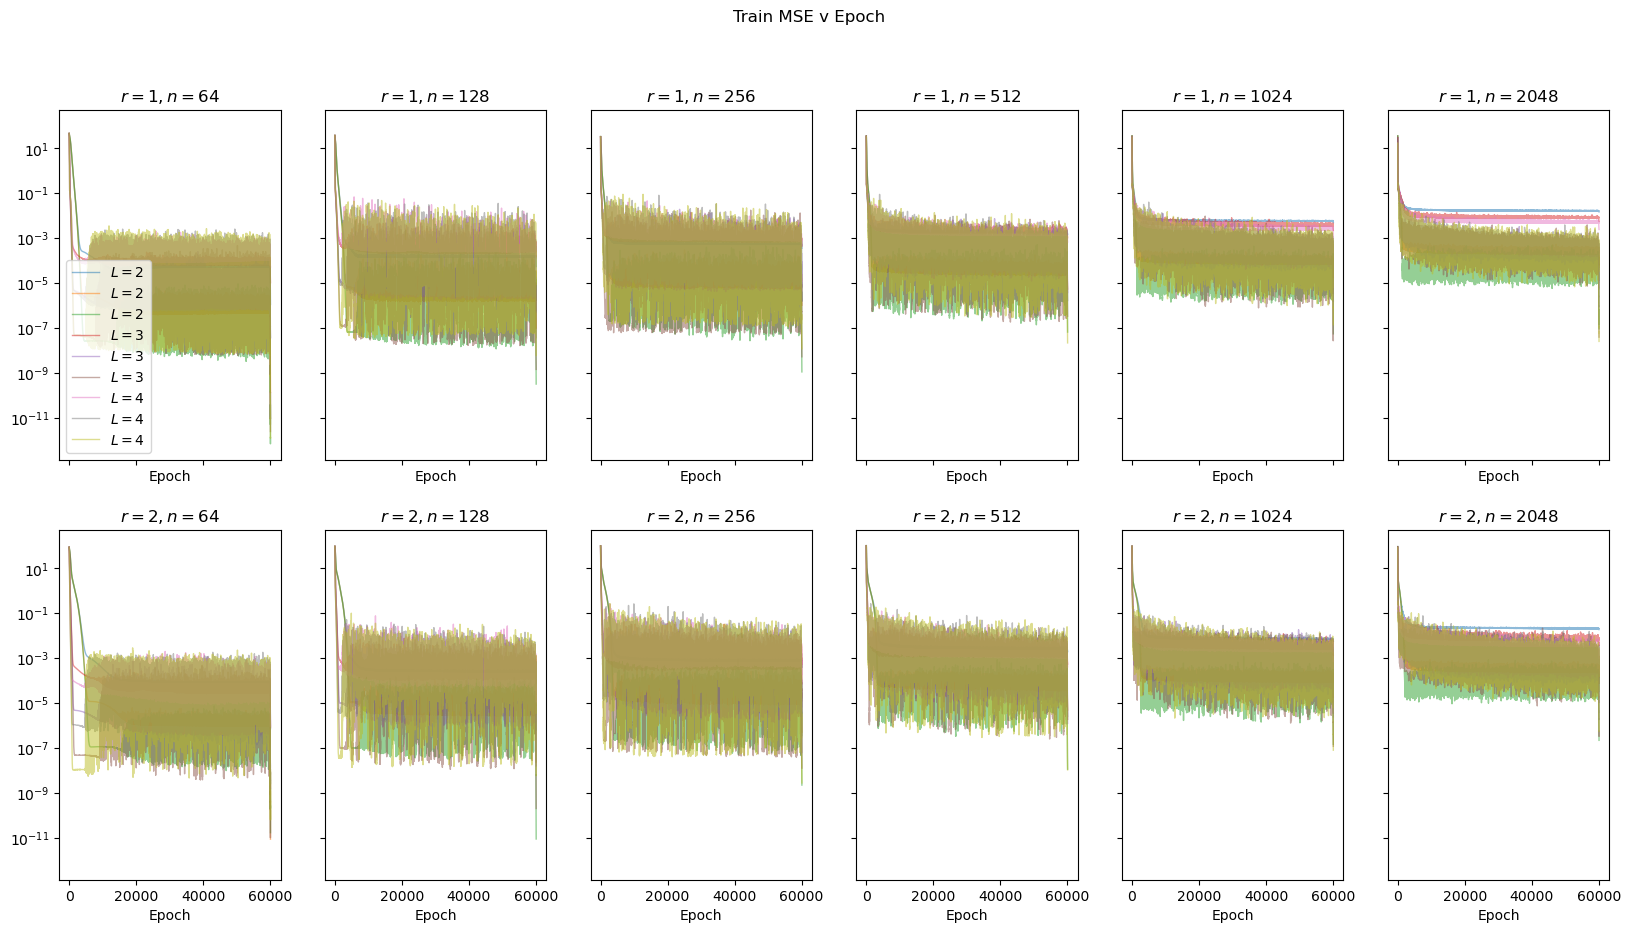

<Figure size 1000x1000 with 0 Axes>

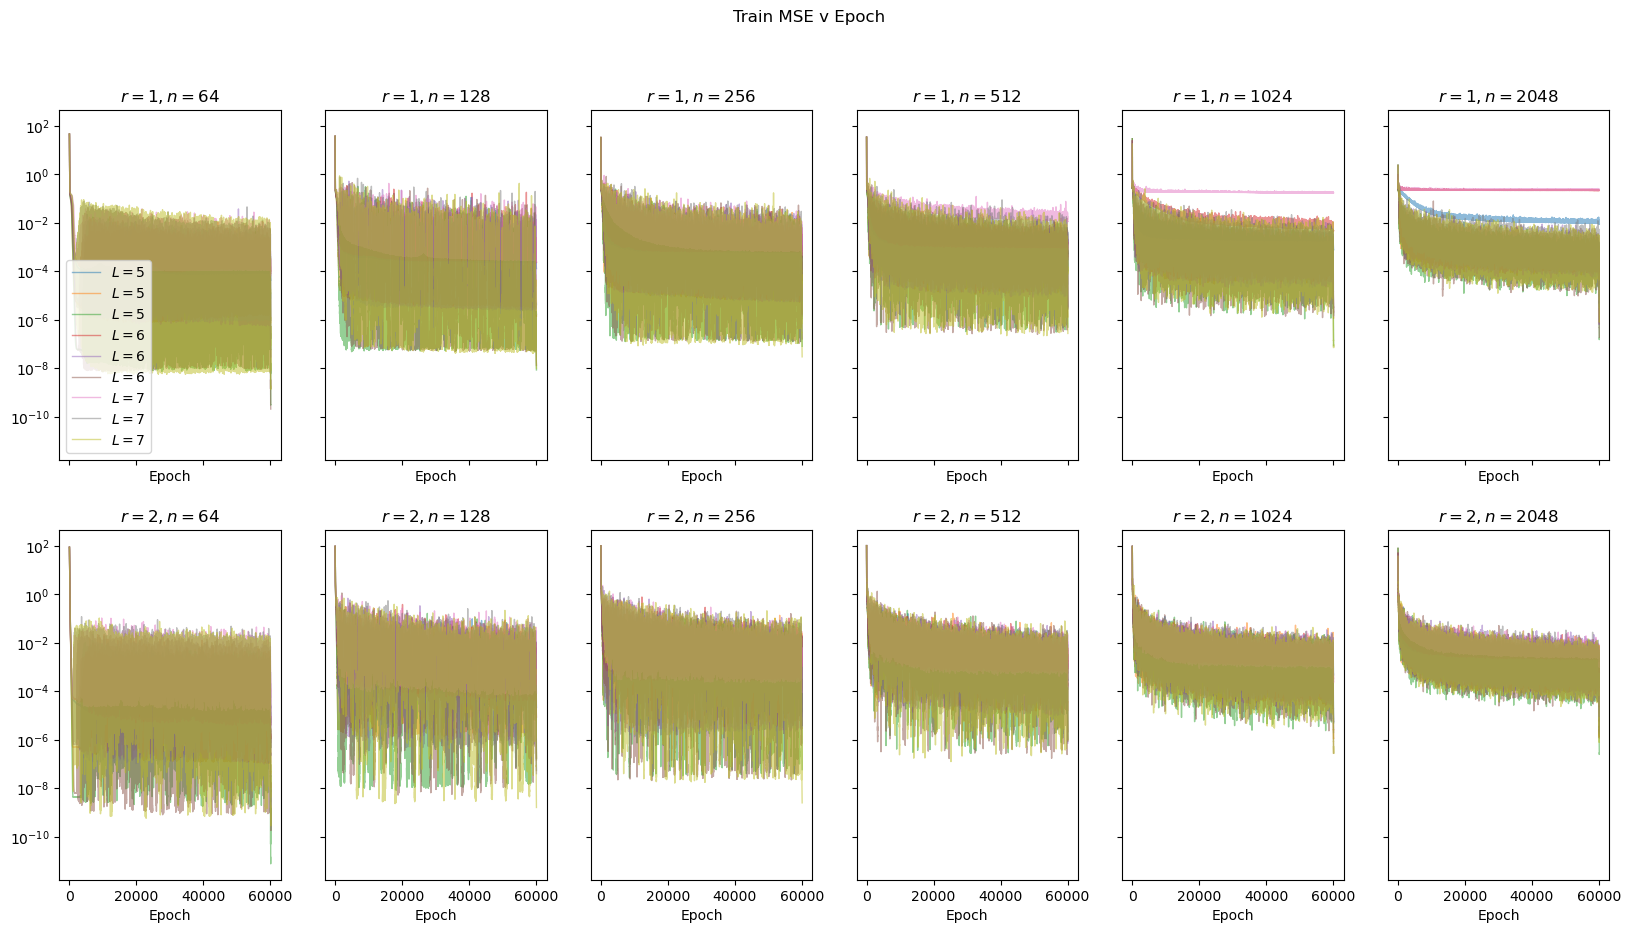

<Figure size 1000x1000 with 0 Axes>

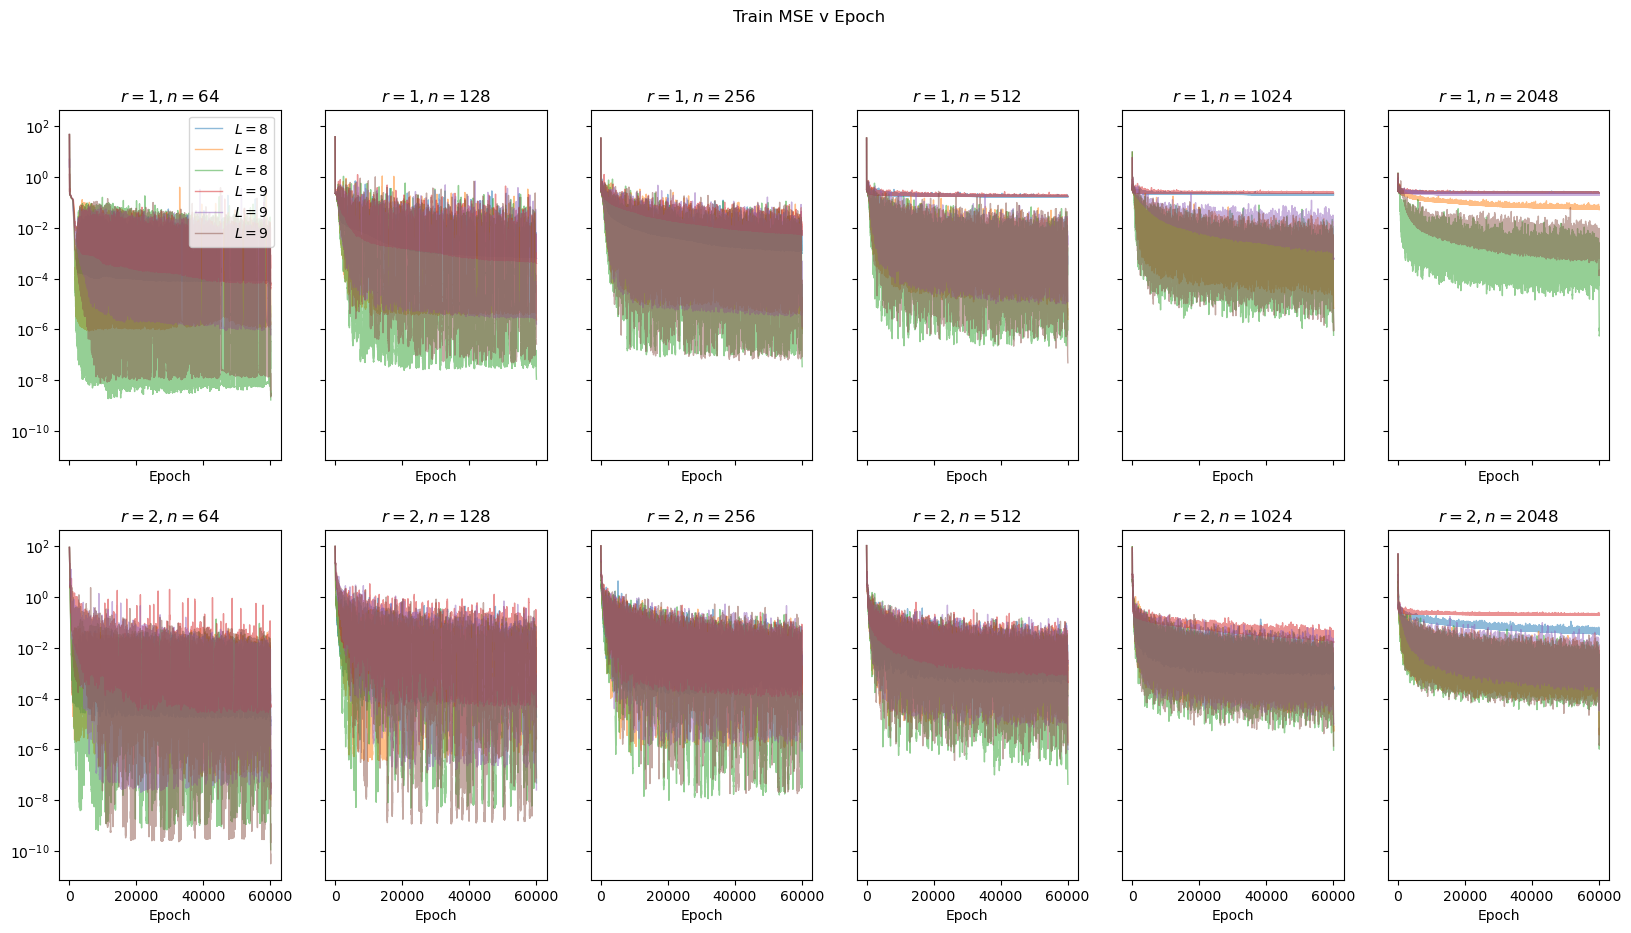

<Figure size 1000x1000 with 0 Axes>

In [11]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if row["L"] <= 4:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse234.png",dpi=300)
plt.show()
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if 4 < row["L"] <= 7:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse567.png",dpi=300)
plt.show()
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if row["L"] > 7:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse8910.png",dpi=300)
plt.show()

## Weight Decay v Epoch


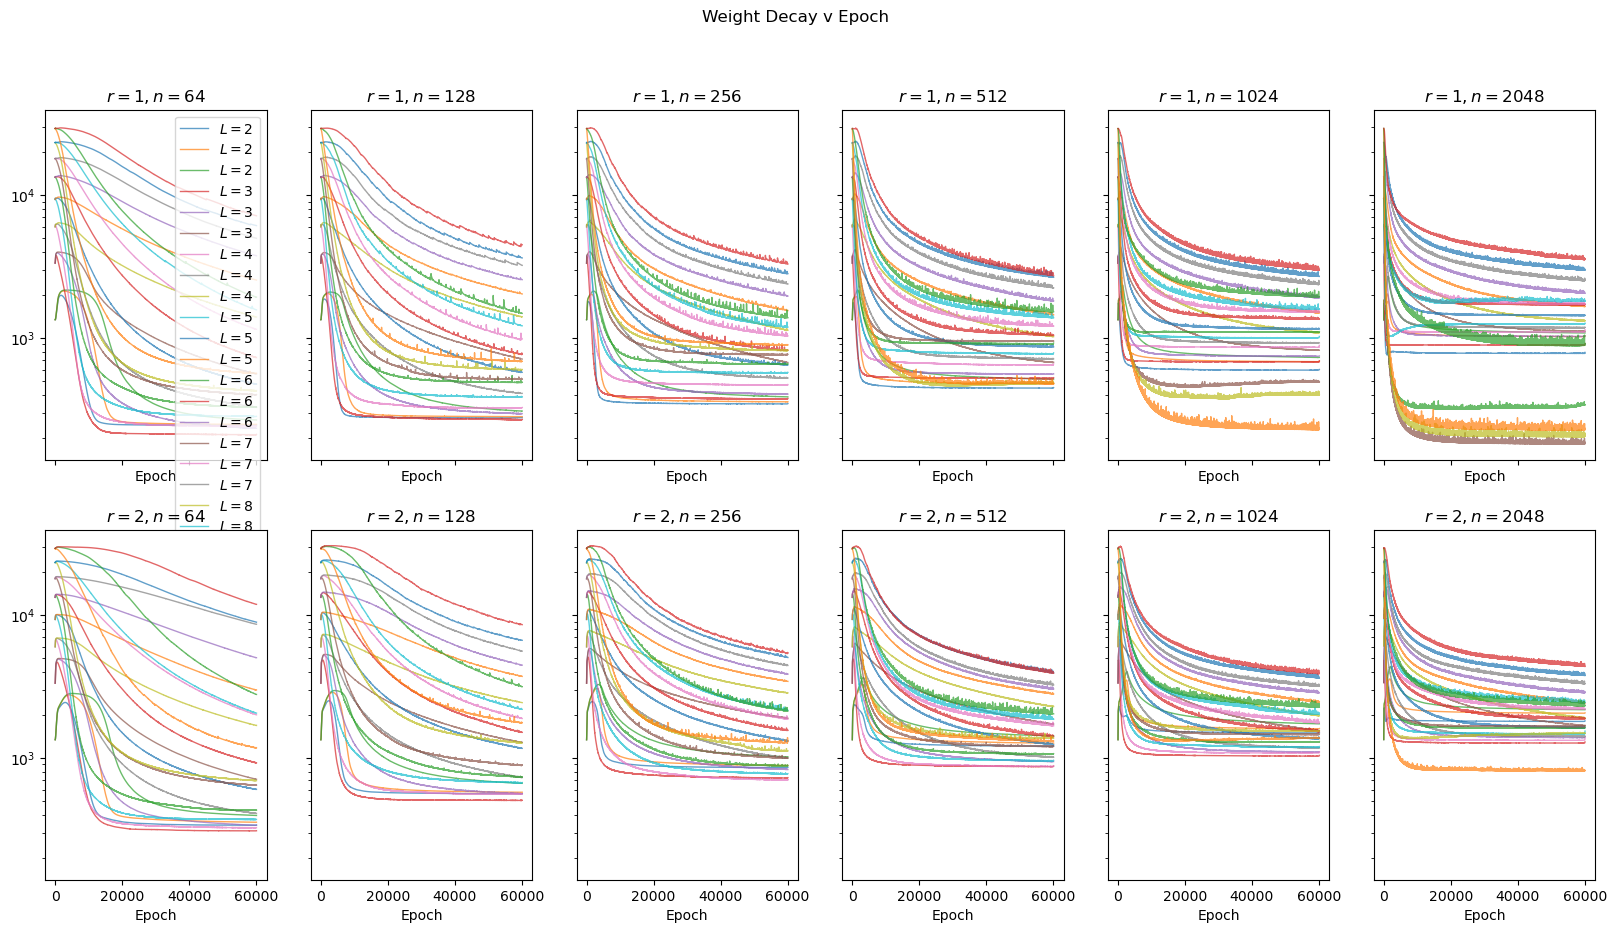

<Figure size 1000x1000 with 0 Axes>

In [12]:
f, ax = plt.subplots(len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    ax[whichrow,whichcol].semilogy(row["Weight Decay"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Weight Decay v Epoch")
f.savefig(job_name+"/weightdecay.png",dpi=300)
plt.show()


## learning rates


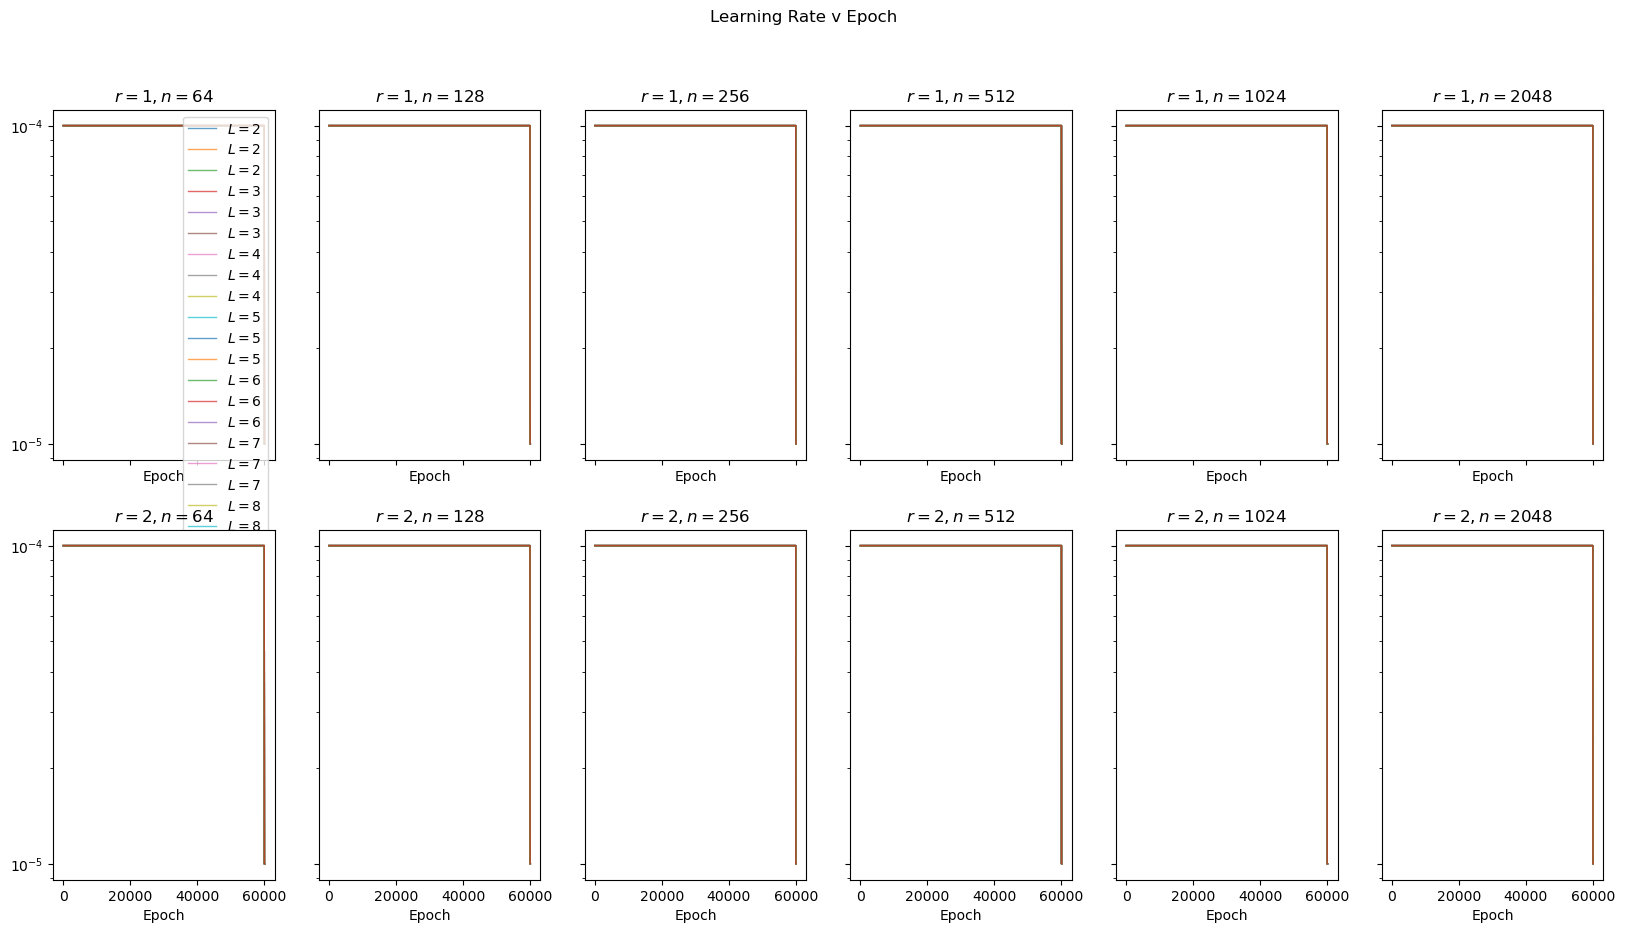

<Figure size 1000x1000 with 0 Axes>

In [13]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    ax[whichrow,whichcol].semilogy(row["Learning Rate"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Learning Rate v Epoch")
f.savefig(job_name+"/LearningRate.png",dpi=300)
plt.show()

# filter out bad training losses

In [14]:
trainMSE_threshold = 1

In [15]:
res[res["Final Train MSE"] >= trainMSE_threshold]

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay


In [16]:
res = res[res["Final Train MSE"] < trainMSE_threshold]
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172
1,1,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.589718, 46.5086, 46.42769, 46.346985, 46.2...","[1340.8862, 1340.8367, 1340.7905, 1340.7479, 1...","[Linear(in_features=20, out_features=1000, bia...",0.828989,linear and relu,1.383045e-10,248.194824
2,1,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.589714, 46.5086, 46.42769, 46.346985, 46.2...","[1340.8962, 1340.8584, 1340.8234, 1340.7914, 1...","[Linear(in_features=20, out_features=1000, bia...",1.350463,linear and relu,1.352305e-12,266.101074
3,1,64,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364998, 45.94851, 45.539864, 45.140266, 44...","[3341.5725, 3341.405, 3341.3562, 3341.423, 334...","[Linear(in_features=20, out_features=1000, bia...",0.864146,linear and relu,1.067578e-05,210.990082
4,1,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539776, 45.140163, 44...","[3341.8257, 3341.9111, 3342.1162, 3342.438, 33...","[Linear(in_features=20, out_features=1000, bia...",0.920398,linear and relu,3.651703e-08,233.148743
...,...,...,...,...,...,...,...,...,...,...,...,...
283,2,2048,8,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.96411, 39.942436, 17.504425, 11.079025, 9....","[23522.932, 23558.658, 23669.26, 23644.451, 23...","[Linear(in_features=20, out_features=1000, bia...",0.446865,linear and relu,5.843687e-06,2445.481201
284,2,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.974598, 39.905914, 17.51395, 11.062577, 9....","[23546.385, 23584.148, 23696.014, 23672.11, 23...","[Linear(in_features=20, out_features=1000, bia...",0.426131,linear and relu,1.615461e-06,3785.873779
285,2,2048,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.85321, 30.131992, 16.265293, 14.77776, 11....","[29146.105, 29150.35, 29162.416, 29153.783, 29...","[Linear(in_features=20, out_features=1000, bia...",0.288516,linear and relu,1.956111e-01,815.180542
286,2,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.607414, 29.141628, 16.225811, 14.667723, 1...","[29419.062, 29443.844, 29472.703, 29486.812, 2...","[Linear(in_features=20, out_features=1000, bia...",0.585600,linear and relu,3.817025e-05,2322.861328


#  determine the lambda parameter that gets the best test MSE for each (r,n,L)

In [17]:
testmse_vs_lambda = res.pivot_table(values="Test MSE",index = ("r","n","L","Activations"),columns=["lambda"])
testmse_vs_lambda

lambda                     0.00001   0.00010   0.00100
r n    L Activations                                  
1 64   2 linear and relu  1.350463  0.828989  0.700179
       3 linear and relu  0.849479  0.920398  0.864146
       4 linear and relu  0.586307  0.695431  0.527374
       5 linear and relu  0.663790  0.649600  0.522226
       6 linear and relu  0.922846  0.560312  1.045836
...                            ...       ...       ...
2 2048 5 linear and relu  0.467060  0.442796  0.443847
       6 linear and relu  0.434013  0.414127  0.438770
       7 linear and relu  0.443487  0.423410  0.505592
       8 linear and relu  0.426131  0.446865  0.619665
       9 linear and relu  0.441169  0.585600  0.288516

[96 rows x 3 columns]

In [18]:
bestlambda = testmse_vs_lambda.idxmin(axis=1)
bestlambda

r  n     L  Activations    
1  64    2  linear and relu    0.00100
         3  linear and relu    0.00001
         4  linear and relu    0.00100
         5  linear and relu    0.00100
         6  linear and relu    0.00010
                                ...   
2  2048  5  linear and relu    0.00010
         6  linear and relu    0.00010
         7  linear and relu    0.00010
         8  linear and relu    0.00001
         9  linear and relu    0.00100
Length: 96, dtype: float64

In [19]:
mask = [row["lambda"] == bestlambda[row["r"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116
13,1,64,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.26493, 45.963314, 45.641537, 45.26838, 44....","[13342.681, 13343.268, 13344.827, 13347.229, 1...","[Linear(in_features=20, out_features=1000, bia...",0.560312,linear and relu,2.971166e-08,729.211487
...,...,...,...,...,...,...,...,...,...,...,...,...
274,2,2048,5,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[79.71219, 15.192655, 7.481189, 6.5791645, 6.1...","[9523.474, 9935.732, 9978.74, 9998.37, 10011.2...","[Linear(in_features=20, out_features=1000, bia...",0.442796,linear and relu,2.102713e-06,1631.374512
277,2,2048,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[50.002655, 11.577784, 8.725554, 7.349521, 6.9...","[13608.162, 13810.587, 13844.476, 13875.923, 1...","[Linear(in_features=20, out_features=1000, bia...",0.414127,linear and relu,2.537568e-06,1883.986328
280,2,2048,7,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[37.246223, 12.361586, 8.803963, 7.6362605, 6....","[18358.867, 18382.854, 18422.562, 18447.814, 1...","[Linear(in_features=20, out_features=1000, bia...",0.423410,linear and relu,2.338378e-06,2198.655518
284,2,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.974598, 39.905914, 17.51395, 11.062577, 9....","[23546.385, 23584.148, 23696.014, 23672.11, 23...","[Linear(in_features=20, out_features=1000, bia...",0.426131,linear and relu,1.615461e-06,3785.873779


In [20]:
res[(res["n"] == 1024)*(res["r"] == 1)]

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
96,1,1024,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[36.607765, 35.88573, 35.185165, 34.53865, 33....","[1339.0693, 1338.0793, 1337.9974, 1338.5742, 1...","[Linear(in_features=20, out_features=1000, bia...",0.343688,linear and relu,5.081204e-03,601.565063
99,1,1024,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[33.840416, 29.984165, 25.52821, 20.100946, 14...","[3344.3174, 3361.3203, 3390.1987, 3431.8408, 3...","[Linear(in_features=20, out_features=1000, bia...",0.359723,linear and relu,2.246182e-03,692.598511
103,1,1024,4,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[31.855402, 16.977081, 1.6775775, 0.86131287, ...","[6029.158, 6093.7285, 6191.7886, 6220.1167, 61...","[Linear(in_features=20, out_features=1000, bia...",0.363736,linear and relu,1.670440e-06,924.193726
107,1,1024,5,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[29.760534, 2.4401667, 1.1145861, 0.58537173, ...","[9379.618, 9495.337, 9486.527, 9501.771, 9490....","[Linear(in_features=20, out_features=1000, bia...",0.354622,linear and relu,8.537313e-08,1498.936401
110,1,1024,6,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[24.025303, 0.7094535, 0.87271017, 0.36767468,...","[13403.335, 13484.93, 13482.354, 13476.819, 13...","[Linear(in_features=20, out_features=1000, bia...",0.340395,linear and relu,1.983739e-06,1919.391724
111,1,1024,7,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[18.114597, 2.2522786, 0.6788666, 0.35922486, ...","[17981.84, 18009.719, 17999.941, 17987.268, 17...","[Linear(in_features=20, out_features=1000, bia...",0.299661,linear and relu,1.756133e-01,493.302399
114,1,1024,8,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[9.607359, 1.6542041, 0.5170057, 0.32104018, 0...","[23267.39, 23277.38, 23254.807, 23227.312, 232...","[Linear(in_features=20, out_features=1000, bia...",0.284970,linear and relu,1.983562e-01,399.765625
117,1,1024,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[5.569807, 3.1159472, 0.90245783, 0.3564454, 0...","[29153.5, 29143.277, 29119.127, 29091.031, 290...","[Linear(in_features=20, out_features=1000, bia...",0.245027,linear and relu,2.315897e-01,228.632233


## Check that most or all ReLU hyperplanes intersect the support of the distributions of the tests

It is straightforward to prove that the hyperplane
$$\mathbf w ^\top \mathbf x + b = 0$$
intersects the hypercube $$\|\mathbf x\|_\infty \le t$$
if and only if $$t  \ge \frac{|b|}{\|\mathbf w\|_1}.$$

TODO write up proof sketch on overleaf

Therefore given a ReLU units $(a_k, \mathbf w_k, b_k)$, if
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} \le \frac{1}{2}$:** then the  hyperplane intersects the support of the distribution for the **"in-distribution"** tests.
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} \in (\frac{1}{2},1]$:** then the hyperplane intersects the support of the distribution for the **"out-of-distribution"** tests but not the "in-distribution" tests
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} > 1$:** then the hyperplanes intersects **neither** the support of the distribution for the "out-of-distribution" tests nor the "in-distribution" tests

In [21]:
r = 2

print("r =",r)
U = np.load(job_name+f"/r{r}U.npy")
Sigma = np.load(job_name+f"/r{r}Sigma.npy")
V = np.load(job_name+f"/r{r}V.npy")
A = np.load(job_name+f"/r{r}A.npy")
B = np.load(job_name+f"/r{r}B.npy")
W = (U*Sigma)@V.T
rowwise1norms = np.linalg.norm(W,axis=1,ord=1)
ratios = np.abs(B) / np.linalg.norm(W,axis=1,ord=1)
rowwise2norms = np.linalg.norm(W,axis=1,ord=2)
units = pd.DataFrame({"R2-cost contribution":np.abs(A)*rowwise2norms,"|b| / ||w||_1":ratios})
units["[-1/2,1/2]"] = ratios <= 1/2
units["[-1,1] but not [-1/2,1/2]"] = (1/2 < ratios) * (ratios <= 1)
units["not [-1,1]"] = ratios > 1
print("\nTOTALS:\n~~~~~~~\n",units.sum())
print("\nunit-wise table:\n~~~~~~~\n")
units


r = 2

TOTALS:
~~~~~~~
 R2-cost contribution         223.147503
|b| / ||w||_1                  0.731792
[-1/2,1/2]                    21.000000
[-1,1] but not [-1/2,1/2]      0.000000
not [-1,1]                     0.000000
dtype: float64

unit-wise table:
~~~~~~~



,R2-cost contribution,|b| / ||w||_1,"[-1/2,1/2]","[-1,1] but not [-1/2,1/2]","not [-1,1]"
0,2.021811,0.032244,True,False,False
1,0.402139,0.044665,True,False,False
2,1.278993,0.028319,True,False,False
3,4.191544,0.006685,True,False,False
4,21.394932,0.022562,True,False,False
5,9.869071,0.033822,True,False,False
6,5.596780,0.005010,True,False,False
7,9.045827,0.015383,True,False,False
8,3.535087,0.055739,True,False,False
9,9.782236,0.013954,True,False,False


# Generalization MSE

## generate data

In [22]:
def gen_data(datasetsize,r,seed,trainsize=2**18,testsize=2**10,d=20,funcseed=42,verbose=False,ood=False,std=0):
    ##Generate data with a true central subspaces of varying dimensions
    #generate X values for training and test sets
    np.random.seed(seed) #set seed for data generation
    trainX = np.random.rand(d,trainsize).astype(np.float32)[:,:datasetsize] - 0.5 #distributed as U[-1/2, 1/2]
    testX = np.random.rand(d,testsize).astype(np.float32) - 0.5 #distributed as U[-1/2, 1/2]
    #out of distribution datagen
    if ood:
        trainX *= 2 #now distributed as U[-1, 1]
        testX *= 2 #now distributed as U[-1, 1]
    ##for each $r$ value create and store data-gen functions and $y$ evaluations
    #geneate params for functions
    k = d+1
    U = np.load(job_name+f"/r{r}U.npy")
    Sigma = np.load(job_name+f"/r{r}Sigma.npy")
    V = np.load(job_name+f"/r{r}V.npy")
    A = np.load(job_name+f"/r{r}A.npy")
    B = np.load(job_name+f"/r{r}B.npy")
    #create functions
    def g(z): #active subspace function
        hidden_layer = (U*Sigma)@z
        hidden_layer = hidden_layer.T + B
        hidden_layer = np.maximum(0,hidden_layer).T
        return A@hidden_layer
    def f(x): #teacher network
        z = V.T@x        
        return g(z)
    #generate data
    trainY = f(trainX).astype(np.float32)
    testY = f(testX).astype(np.float32)
    #move data to device
    if verbose:
        print("device: {}".format(device))
    trainX = torch.from_numpy(trainX).T.to(device)
    trainY = torch.from_numpy(trainY).to(device)
    testX = torch.from_numpy(testX).T.to(device)
    testY = torch.from_numpy(testY).to(device)
    if verbose:
        print("trainX shape = {} trainY shape = {}".format(
            trainX.shape,
            trainY.shape
        ))
    return trainX,trainY,testX,testY


In [23]:
generalizationX,generalizationYr1 = gen_data(2048,r=1,seed=101)[:2]
generalizationX,generalizationYr2 = gen_data(2048,r=2,seed=101)[:2]
generalizationY = {1:generalizationYr1,2:generalizationYr2}

In [24]:
generalizationX.min(),generalizationX.max()

(tensor(-0.4999, device='cuda:0'), tensor(0.5000, device='cuda:0'))

## compute MSE

In [25]:
with torch.no_grad():
    generalization = []
    for rownum, row in res.iterrows():
        predY = row["Model"](generalizationX)
        err = nn.functional.mse_loss(predY[:,0],generalizationY[row["r"]]).item()
        generalization.append(err)
    res["Generalization MSE"] = generalization

/tmp/ipykernel_1462472/2767959317.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Generalization MSE"] = generalization


In [26]:
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Generalization MSE
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172,0.487092
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067,0.641505
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991,0.286370
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116,0.289581
13,1,64,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.26493, 45.963314, 45.641537, 45.26838, 44....","[13342.681, 13343.268, 13344.827, 13347.229, 1...","[Linear(in_features=20, out_features=1000, bia...",0.560312,linear and relu,2.971166e-08,729.211487,0.325483
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,2,2048,5,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[79.71219, 15.192655, 7.481189, 6.5791645, 6.1...","[9523.474, 9935.732, 9978.74, 9998.37, 10011.2...","[Linear(in_features=20, out_features=1000, bia...",0.442796,linear and relu,2.102713e-06,1631.374512,0.180614
277,2,2048,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[50.002655, 11.577784, 8.725554, 7.349521, 6.9...","[13608.162, 13810.587, 13844.476, 13875.923, 1...","[Linear(in_features=20, out_features=1000, bia...",0.414127,linear and relu,2.537568e-06,1883.986328,0.181664
280,2,2048,7,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[37.246223, 12.361586, 8.803963, 7.6362605, 6....","[18358.867, 18382.854, 18422.562, 18447.814, 1...","[Linear(in_features=20, out_features=1000, bia...",0.423410,linear and relu,2.338378e-06,2198.655518,0.177232
284,2,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.974598, 39.905914, 17.51395, 11.062577, 9....","[23546.385, 23584.148, 23696.014, 23672.11, 23...","[Linear(in_features=20, out_features=1000, bia...",0.426131,linear and relu,1.615461e-06,3785.873779,0.186218


# Out of Distribution MSE

## generate data

In [27]:
oodX,oodYr1 = gen_data(2048,r=1,seed=101,ood=True)[:2] #generate out of distribution data
oodX,oodYr2 = gen_data(2048,r=2,seed=101,ood=True)[:2]
oodY = {1:oodYr1,2:oodYr2}

In [28]:
oodX.min(),oodX.max()

(tensor(-0.9999, device='cuda:0'), tensor(1.0000, device='cuda:0'))

## compute MSE

In [29]:
with torch.no_grad():
    ood_errs = []
    for rownum, row in res.iterrows():
        predY = row["Model"](oodX)
        err = nn.functional.mse_loss(predY[:,0],oodY[row["r"]]).item()
        ood_errs.append(err)
    res["Out of Distribution MSE"] = ood_errs

/tmp/ipykernel_1462472/1177832019.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Out of Distribution MSE"] = ood_errs


In [30]:
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Generalization MSE,Out of Distribution MSE
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172,0.487092,2.898517
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067,0.641505,3.530614
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991,0.286370,1.355756
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116,0.289581,1.360794
13,1,64,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.26493, 45.963314, 45.641537, 45.26838, 44....","[13342.681, 13343.268, 13344.827, 13347.229, 1...","[Linear(in_features=20, out_features=1000, bia...",0.560312,linear and relu,2.971166e-08,729.211487,0.325483,1.551712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,2,2048,5,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[79.71219, 15.192655, 7.481189, 6.5791645, 6.1...","[9523.474, 9935.732, 9978.74, 9998.37, 10011.2...","[Linear(in_features=20, out_features=1000, bia...",0.442796,linear and relu,2.102713e-06,1631.374512,0.180614,1.179050
277,2,2048,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[50.002655, 11.577784, 8.725554, 7.349521, 6.9...","[13608.162, 13810.587, 13844.476, 13875.923, 1...","[Linear(in_features=20, out_features=1000, bia...",0.414127,linear and relu,2.537568e-06,1883.986328,0.181664,0.994698
280,2,2048,7,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[37.246223, 12.361586, 8.803963, 7.6362605, 6....","[18358.867, 18382.854, 18422.562, 18447.814, 1...","[Linear(in_features=20, out_features=1000, bia...",0.423410,linear and relu,2.338378e-06,2198.655518,0.177232,1.061643
284,2,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.974598, 39.905914, 17.51395, 11.062577, 9....","[23546.385, 23584.148, 23696.014, 23672.11, 23...","[Linear(in_features=20, out_features=1000, bia...",0.426131,linear and relu,1.615461e-06,3785.873779,0.186218,1.312074


# Active Subspace

## evaluate gradients and compute singular values and active subspaces

In [31]:
generalizationY

{1: tensor([  2.8498,   1.3553,  -7.2570,  ...,   0.7691, -12.6291,   1.3051],
        device='cuda:0'),
 2: tensor([ 1.5574,  7.7949, 19.1428,  ...,  8.1604, 10.2077,  3.3550],
        device='cuda:0')}

In [32]:
grads = []
sv = []
active_subspace = []
subspace_dist = []

for rownum, row in res.iterrows():
    #compute ground truth active subspace
    funcseed = 42
    d = 20
    k = d+1
    U = np.load(job_name+f"/r{row['r']}U.npy")
    Sigma = np.load(job_name+f"/r{row['r']}Sigma.npy")
    V = np.load(job_name+f"/r{row['r']}V.npy")
    W = np.load(job_name+f"/r{row['r']}W.npy")
    A = np.load(job_name+f"/r{row['r']}A.npy")
    B = np.load(job_name+f"/r{row['r']}B.npy")

    #evaluate gradients
    generalizationX.requires_grad = True
    predY = row["Model"](generalizationX)
    grad = torch.autograd.grad(predY, generalizationX,
                            grad_outputs=torch.ones_like(predY),
                            create_graph=True)[0].detach().cpu().numpy()
    grads.append(grad)
    #compute active subspace and singular values
    Uhat,Shat,VhatT = np.linalg.svd(grad)
    Vhat = VhatT.T[:,:row["r"]] #form the basis for the active subspace
    active_subspace.append(Vhat)
    sv.append(Shat)

    subspace_dist.append(np.linalg.norm(V@V.T - Vhat@Vhat.T,2))

res["Gradient Evaluations"] = grads
res["Gradient Singular Values"] = sv
res["Active Subspace"] = active_subspace
res["Active Subspace Distance"] = subspace_dist
res["Active Subspace Alignment Angle (Degrees)"] = np.degrees(np.arcsin(res["Active Subspace Distance"]))

res

/tmp/ipykernel_1462472/2504222643.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Gradient Evaluations"] = grads
/tmp/ipykernel_1462472/2504222643.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Gradient Singular Values"] = sv
/tmp/ipykernel_1462472/2504222643.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Generalization MSE,Out of Distribution MSE,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Active Subspace Alignment Angle (Degrees)
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172,0.487092,2.898517,"[[0.49225992, 0.20404717, -4.819542, -1.480701...","[852.285, 47.673088, 38.30203, 25.33333, 16.65...","[[-0.00482929], [0.030902093], [-0.58861816], ...",0.077546,4.447505
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067,0.641505,3.530614,"[[-0.32209662, 0.32306653, -3.9552255, -0.9743...","[893.8993, 78.973915, 37.67027, 20.14995, 17.3...","[[0.023482155], [-0.03737758], [0.5848328], [0...",0.074022,4.245004
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991,0.286370,1.355756,"[[-0.044873916, 0.01561475, -5.2166705, -1.686...","[922.734, 52.75246, 44.24988, 26.602844, 5.510...","[[0.014575577], [-0.014679418], [0.59677315], ...",0.065065,3.730590
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116,0.289581,1.360794,"[[0.60369194, 0.46010262, -4.986182, -1.866740...","[915.90265, 61.736324, 47.7781, 13.814477, 2.9...","[[-0.010039536], [0.02317976], [-0.5923792], [...",0.062385,3.576708
13,1,64,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.26493, 45.963314, 45.641537, 45.26838, 44....","[13342.681, 13343.268, 13344.827, 13347.229, 1...","[Linear(in_features=20, out_features=1000, bia...",0.560312,linear and relu,2.971166e-08,729.211487,0.325483,1.551712,"[[0.36864483, 1.1198897, -6.0852323, -2.85283,...","[918.9901, 70.3083, 52.68735, 31.593893, 0.000...","[[-0.014556083], [0.0058331867], [-0.6026002],...",0.055831,3.200547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,2,2048,5,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[79.71219, 15.192655, 7.481189, 6.5791645, 6.1...","[9523.474, 9935.732, 9978.74, 9998.37, 10011.2...","[Linear(in_features=20, out_features=1000, bia...",0.442796,linear and relu,2.102713e-06,1631.374512,0.180614,1.179050,"[[3.34894, 0.90394247, 2.3241825, 0.6269102, 2...","[852.531, 541.0722, 40.319946, 38.49079, 34.00...","[[-0.15298311, -0.24707069], [0.032132775, -0....",0.018873,1.081427
277,2,2048,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[50.002655, 11.577784, 8.725554, 7.349521, 6.9...","[13608.162, 13810.587, 13844.476, 13875.923, 1...","[Linear(in_features=20, out_features=1000, bia...",0.414127,linear and relu,2.537568e-06,1883.986328,0.181664,0.994698,"[[2.249783, -0.060157873, 1.9174476, 1.60917, ...","[857.21765, 543.4386, 45.87483, 43.235165, 39....","[[-0.15188922, -0.24532449], [0.031130487, -0....",0.019709,1.129318
280,2,2048,7,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[37.246223, 12.361586, 8.803963, 7.6362605, 6....","[18358.867, 18382.854, 18422.562, 18447.814, 1...","[Linear(in_features=20, out_features=1000, bia...",0.423410,linear and relu,2.338378e-06,2198.655518,0.177232,1.061643,"[[3.3334284, 0.9782294, 1.1955411, 0.8818506, ...","[850.62964, 

## plot of singular values

In [33]:
# colors = {(1,64):"tab:blue",(1,2048):"tab:cyan",(2,64):"tab:orange",(2,128):"tab:pink",(2,256):"tab:red",(2,2048):"tab:purple"}

In [34]:
res.n.unique()

array([  64,  128,  256,  512, 1024, 2048])

0 0
1,64,2 [1.8833015e+01 1.0534364e+00 8.4636325e-01 5.5979282e-01 3.6796227e-01
 2.1231724e-01 1.8612662e-01 1.0565626e-01 8.8861130e-02 8.1363156e-02
 5.8068726e-02 4.9981620e-02 2.8227830e-02 2.3241889e-02 1.8226132e-02
 1.2971178e-02 1.1680914e-02 5.9117042e-03 5.2922987e-03 3.7607716e-03] 0 0
0 0
1,64,3 [1.9752571e+01 1.7450935e+00 8.3240324e-01 4.4525519e-01 3.8318977e-01
 3.1964874e-01 3.0971283e-01 2.3560101e-01 8.7219723e-02 6.8578489e-02
 4.6525419e-02 4.1427050e-02 3.7356753e-02 2.3979606e-02 2.1620855e-02
 2.0846246e-02 1.3120949e-02 1.1532103e-02 7.4532810e-03 5.2172332e-03] 0 0
0 0
1,64,4 [2.03897343e+01 1.16567576e+00 9.77793515e-01 5.87845385e-01
 1.21761661e-06 5.54481687e-07 4.65885392e-07 3.75279740e-07
 2.74344274e-07 2.27882893e-07 1.98784335e-07 1.37336912e-07
 1.25306883e-07 1.03537396e-07 9.28808248e-08 8.15586603e-08
 6.39164952e-08 6.23070804e-08 4.47528770e-08 3.57498067e-08] 0 0
0 0
1,64,5 [2.0238781e+01 1.3641930e+00 1.0557568e+00 3.0525970e-01 6.4511255e-

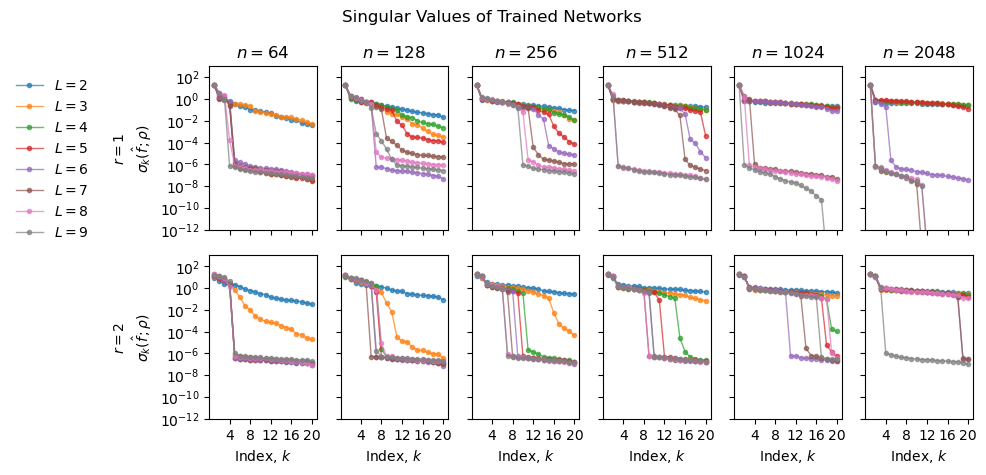

In [35]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(10,4.8))#len(res.r.unique()),len(res.n.unique())
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    print(whichrow,whichcol)
    #whichax = row['L'] - 2
#     color = colors[(row['L'])]
    print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
    ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
    ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
    ax[whichrow,whichcol].set_ylim(10**-9,10**3)
    ax[0,whichcol].set_title(rf"$n={row['n']}$")
    ax[-1,whichcol].set_xlabel(rf"Index, $k$")
plt.subplot(2,len(res.n.unique()),1)
leg = plt.legend()
leg = plt.legend(bbox_to_anchor=(-1, 1))
leg.get_frame().set_edgecolor('b')
leg.get_frame().set_linewidth(0.0)
plt.subplot(2,len(res.n.unique()),1)
plt.ylabel(r"$r=1$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
plt.yticks([10**p for p in range(-12,3,2)])
plt.subplot(2,len(res.n.unique()),len(res.n.unique())+1)
plt.ylabel(r"$r=2$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
plt.yticks([10**p for p in range(-12,3,2)])
plt.suptitle("Singular Values of Trained Networks")
plt.tight_layout()
plt.savefig(job_name+"/sv.png",dpi=300,bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

#  determine the L parameter that gets the best test MSE for each (r,n)

In [36]:
testmse_vs_L = res.pivot_table(values="Test MSE",index = ("r","n","Activations"),columns=["L"])
testmse_vs_L = testmse_vs_L.iloc[:,1:]
testmse_vs_L

L                               3          4          5          6          7  \
r n    Activations                                                              
1 64   linear and relu   0.849479   0.527374   0.522226   0.560312   1.168659   
  128  linear and relu   0.512561   0.462753   0.490750   0.511482   0.551592   
  256  linear and relu   0.506676   0.523423   0.483403   0.463999   0.452545   
  512  linear and relu   0.404238   0.420849   0.405728   0.367030   0.352659   
  1024 linear and relu   0.359723   0.363736   0.354622   0.340395   0.299661   
  2048 linear and relu   0.350350   0.331261   0.357457   0.265245   0.252219   
2 64   linear and relu  12.406704  14.905621  14.622814  13.806177  21.512268   
  128  linear and relu   6.660488   8.684305   8.782684   9.192224   7.495980   
  256  linear and relu   2.300075   0.928132   0.798902   0.885638   0.856590   
  512  linear and relu   0.770835   0.587871   0.611667   0.498845   0.576581   
  1024 linear and relu   0.503652   0.480739   0.473935   0.466012   0.465032   
  2048 linear and relu   0.419641   0.401414   0.442796   0.414127   0.423410   

L                               8          9  
r n    Activations                            
1 64   linear and relu   1.013373   0.843174  
  128  linear and relu   0.505232   0.476292  
  256  linear and relu   0.438091   0.455112  
  512  linear and relu   0.305643   0.299005  
  1024 linear and relu   0.284970   0.245027  
  2048 linear and relu   0.251924   0.251749  
2 64   linear and relu  30.345915  22.405424  
  128  linear and relu   7.531805  10.821593  
  256  linear and relu   0.921839   0.790097  
  512  linear and relu   0.544794   0.581702  
  1024 linear and relu   0.466928   0.450094  
  2048 linear and relu   0.426131   0.288516

In [37]:
bestL = testmse_vs_L.idxmin(axis=1)
bestL

r  n     Activations    
1  64    linear and relu    5
   128   linear and relu    4
   256   linear and relu    8
   512   linear and relu    9
   1024  linear and relu    9
   2048  linear and relu    9
2  64    linear and relu    3
   128   linear and relu    3
   256   linear and relu    9
   512   linear and relu    6
   1024  linear and relu    9
   2048  linear and relu    9
dtype: int64

In [38]:
mask = [row["L"] == bestL[row["r"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]
bestLres

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Generalization MSE,Out of Distribution MSE,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Active Subspace Alignment Angle (Degrees)
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116,0.289581,1.360794,"[[0.60369194, 0.46010262, -4.986182, -1.866740...","[915.90265, 61.736324, 47.7781, 13.814477, 2.9...","[[-0.010039536], [0.02317976], [-0.5923792], [...",0.062385,3.576708
32,1,128,4,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[37.553375, 36.891846, 36.200607, 35.46246, 34...","[6010.4233, 6011.6494, 6013.8057, 6016.7896, 6...","[Linear(in_features=20, out_features=1000, bia...",0.462753,linear and relu,6.269481e-09,1406.933838,0.247534,1.074972,"[[0.72656405, 0.20942949, -3.8497522, -1.63509...","[907.31244, 50.554245, 39.77569, 31.398623, 24...","[[-0.0069611594], [0.026621688], [-0.59518707]...",0.047283,2.710137
68,1,256,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[33.391937, 31.376919, 24.070032, 8.292901, 5....","[23328.834, 23335.32, 23367.703, 23419.604, 23...","[Linear(in_features=20, out_features=1000, bia...",0.438091,linear and relu,3.387789e-08,2824.277588,0.199239,0.859099,"[[0.57359034, 0.029404864, -4.9429774, -1.6286...","[921.3147, 58.533012, 45.13802, 40.84886, 31.2...","[[-0.0075621065], [0.019036183], [-0.5957496],...",0.039050,2.237945
93,1,512,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[33.647774, 5.2821555, 3.415135, 2.674631, 1.1...","[29095.363, 29162.777, 29134.959, 29150.13, 29...","[Linear(in_features=20, out_features=1000, bia...",0.299005,linear and relu,1.704516e-01,478.947693,0.058997,0.409249,"[[0.40629858, -0.030208424, -7.708183, -1.9653...","[937.186, 83.45569, 3.4276993e-05, 2.3625207e-...","[[-0.0071539697], [0.009569455], [-0.5970736],...",0.015971,0.915093
117,1,1024,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[5.569807, 3.1159472, 0.90245783, 0.3564454, 0...","[29153.5, 29143.277, 29119.127, 29091.031, 290...","[Linear(in_features=20, out_features=1000, bia...",0.245027,linear and relu,2.315897e-01,228.632233,0.005973,0.052769,"[[-0.048987824, 0.1282172, -6.526225, -1.79568...","[924.5731, 3.9053186e-05, 2.1067906e-05, 1.412...","[[0.004489517], [-0.011750535], [0.59809947], ...",0.011322,0.648741
141,1,2048,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[1.3397449, 0.3613227, 0.34461892, 0.33319703,...","[29148.104, 29092.123, 29027.451, 28953.01, 28...","[Linear(in_features=20, out_features=1000, bia...",0.251749,linear and relu,2.354907e-01,227.927383,0.003570,0.019620,"[[-0.08450638, 0.11093413, -6.43332, -1.784751...","[922.99005, 3.126556e-05, 2.2677068e-05, 1.019...","[[0.0078262165], [-0.010273715], [0.5957959], ...",0.007592,0.434990
148,2,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[87.76813, 87.21741, 86.67223, 86.13261, 85.59...","[3341.9463, 3342.1523, 3342.4937, 3342.9634, 3...","[Linear(in_features=20, out_features=1000, bia...",12.406704,linear and relu,1.608457e-09,337.483093,12.051430,47.100479,"[[1.9589869, -1.5124367, 1.5448408, -0.9545201...","[520.97833, 343.9463, 204.18413, 141.35165, 28...","[[-0.1004008, 0.30475265], [-0.09660572, -0.34...",0.946737,71.215693
171,2,128,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[95.94873, 95.09592, 94.24827, 93.410515, 92.5...","[3341.7356, 3341.8884, 3342.3984, 3343.2583, 3...","[Linear(in_features=20, out_features=1000, bia...",6.660488,linear and relu,2.473655e-05,505.176758,7.020105,33.163376,"[[2.3290534, -0.048540995, 1.8409125, 2.207726...","[637.8865, 330.36887, 201.20686, 166.96735, 14...","[[-0.24519563, -0.26685506], [

# Plots of L vs Test error and n vs Generalization metrics with/without linear layers

In [39]:
res.r.unique()

array([1, 2])

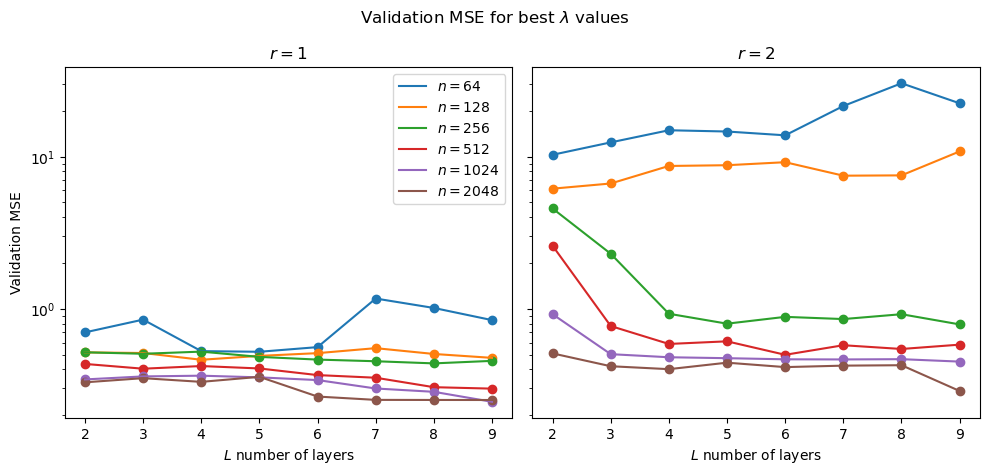

In [40]:
f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=True, figsize=(10,4.8))
for rnum,r in enumerate(res.r.unique()):
    for n in res.n.unique():
        res_rn = res[(res.r == r) * (res.n == n)]
        ax[rnum].scatter(res_rn.L,res_rn[["Test MSE"]])
        ax[rnum].semilogy(res_rn.L,res_rn[["Test MSE"]],label=rf"$n={n}$")
    ax[rnum].set_xlabel("$L$ number of layers")
    ax[rnum].set_title(rf"$r={r}$")
ax[0].legend()
ax[0].set_ylabel("Validation MSE")
f.suptitle(rf"Validation MSE for best $\lambda$ values")
f.tight_layout()
f.savefig(job_name+f"/Validation MSE.png",dpi=300)
plt.show()

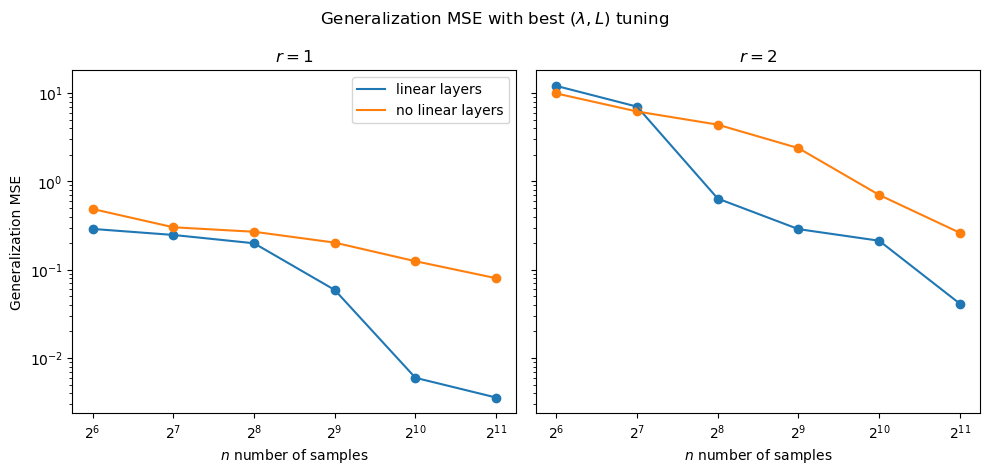

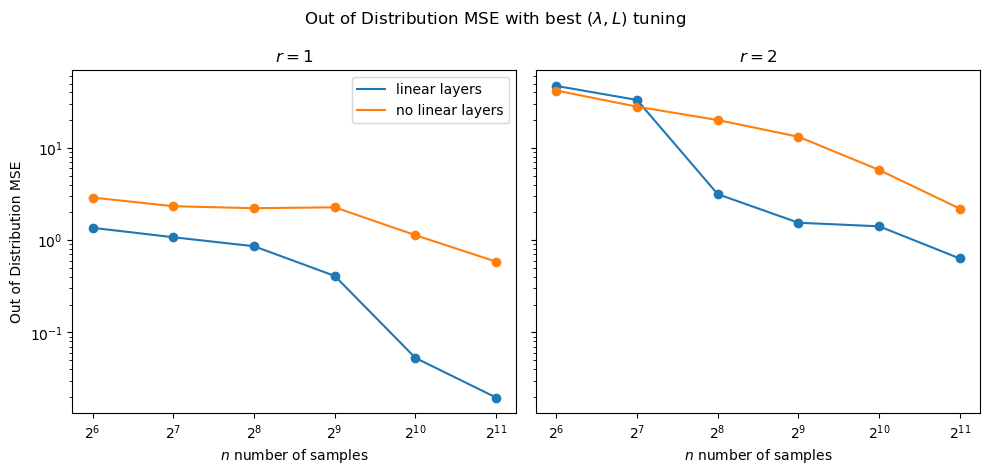

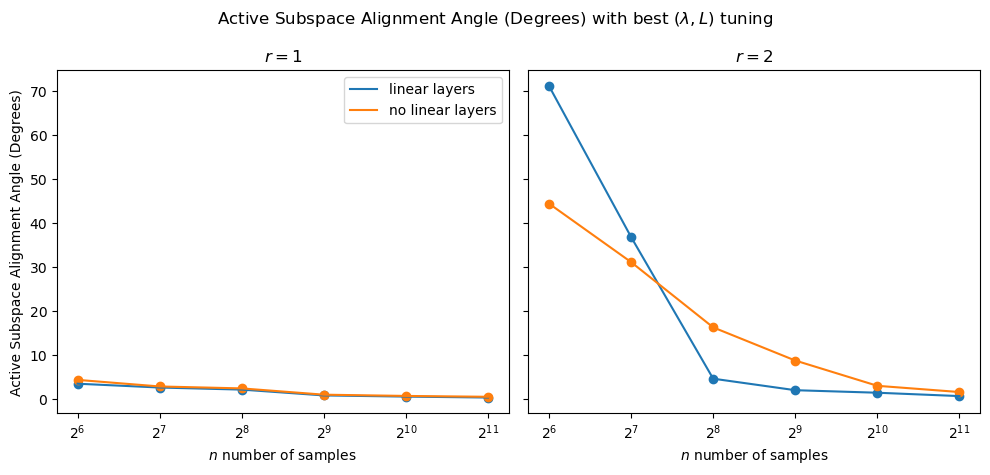

In [41]:
for metric in ['Generalization MSE', 'Out of Distribution MSE','Active Subspace Alignment Angle (Degrees)']:
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=True, figsize=(10,4.8))
    for rnum,r in enumerate(res.r.unique()):
        plt.subplot(1,2,r)
        #best L
        curr = bestLres[bestLres.r == r]
        ax[rnum].scatter(curr.n,curr[[metric]])
        ax[rnum].plot(curr.n,curr[[metric]],label=rf"linear layers")
        #no linear layers
        no_lin_layers = res[(res.r == r) * (res.L == 2)]
        ax[rnum].scatter(no_lin_layers.n,no_lin_layers[[metric]])
        ax[rnum].plot(no_lin_layers.n,no_lin_layers[[metric]],label=rf"no linear layers")
        #plotting extras
        ax[rnum].set_xlabel("$n$ number of samples")
        ax[rnum].set_xscale("log",base=2)
        if metric != 'Active Subspace Alignment Angle (Degrees)':
            ax[rnum].set_yscale("log",base=10)
        ax[rnum].set_title(rf"$r={r}$")
    ax[0].set_ylabel(f"{metric}")
    ax[0].legend()
    plt.suptitle(f"{metric}" + r" with best $(\lambda,L)$ tuning")
    plt.tight_layout()
    plt.savefig(job_name+f"/{metric}.png",dpi=300)
    plt.show()

# Final Table

In [42]:
res.loc[(res.L == 2),"Activations"] = "Shallow ReLU"

In [43]:
bestLres = pd.concat((res[(res.L == 2)],bestLres))

In [44]:
bestLres.shape

(24, 19)

In [45]:
pivot_table = bestLres.pivot_table(index=("r","n","Activations"))
print(pivot_table.shape)
pivot_table

TypeError: agg function failed [how->mean,dtype->object]

In [46]:
pivot_table.idxmin(axis=0)

NameError: name 'pivot_table' is not defined

In [ ]:
pivot_table_latex = pivot_table.drop(["Final Weight Decay"],axis=1)
pivot_table_latex = pivot_table_latex[["L","lambda","Final Train MSE","Generalization MSE","Out of Distribution MSE","Active Subspace Alignment Angle (Degrees)"]]
pivot_table_latex.to_latex(float_format="%.2e")

In [ ]:
pivot_table_latex

# Training Time Plots for selected models

## Train MSE v Epoch

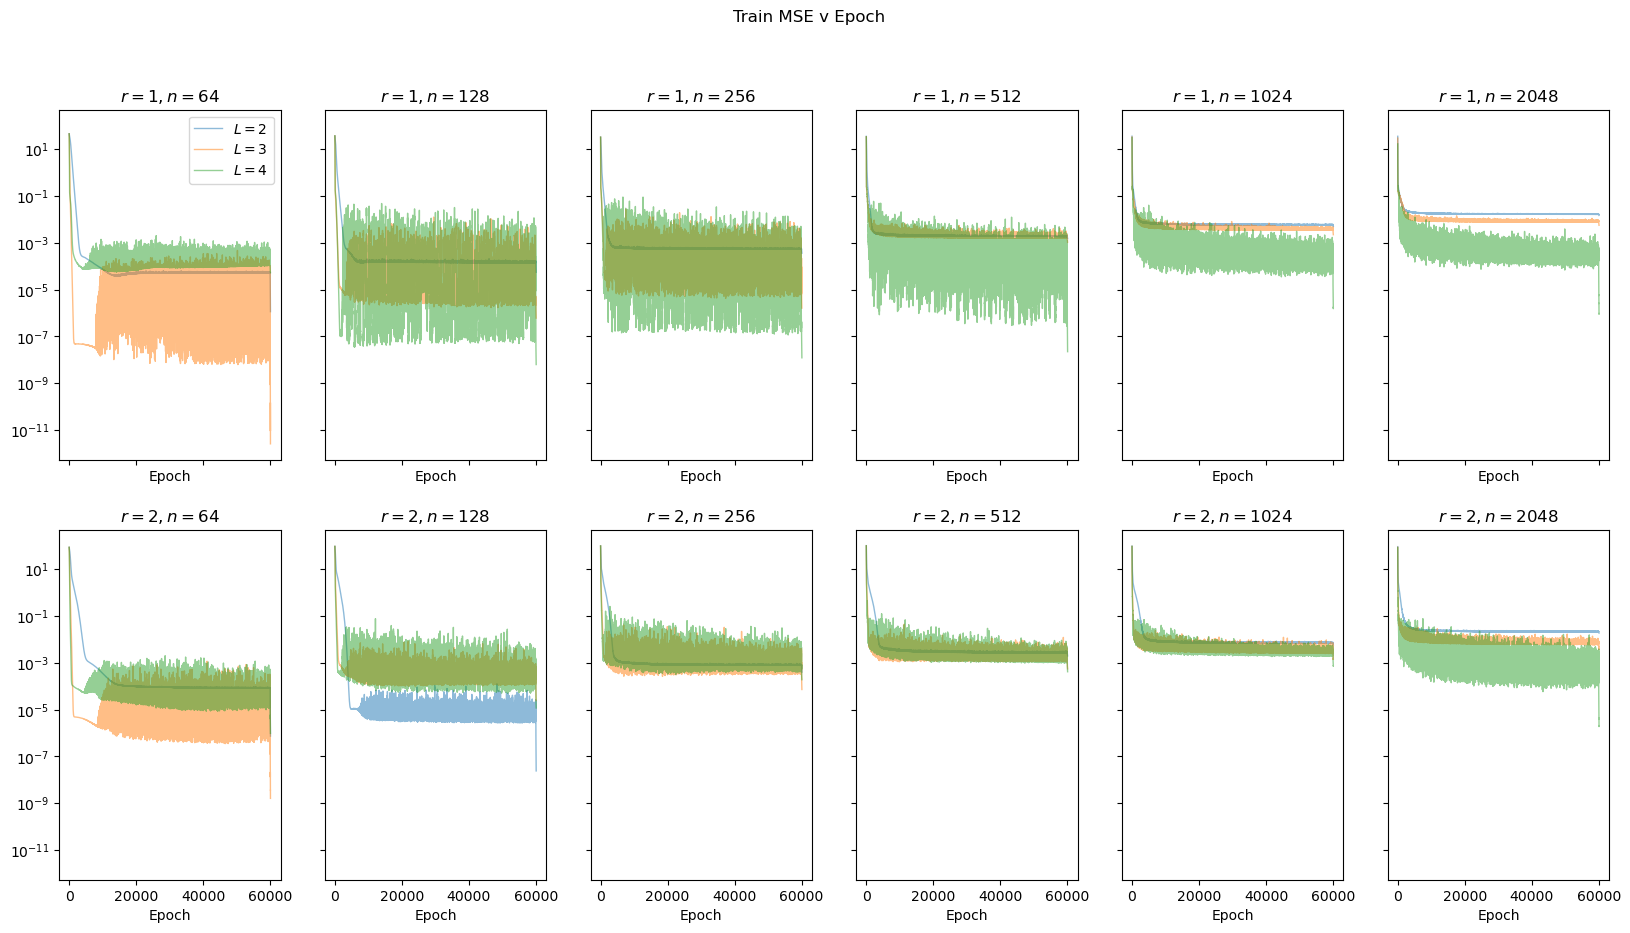

<Figure size 1000x1000 with 0 Axes>

In [47]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if row["L"] <= 4:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse234.png",dpi=300)
plt.show()

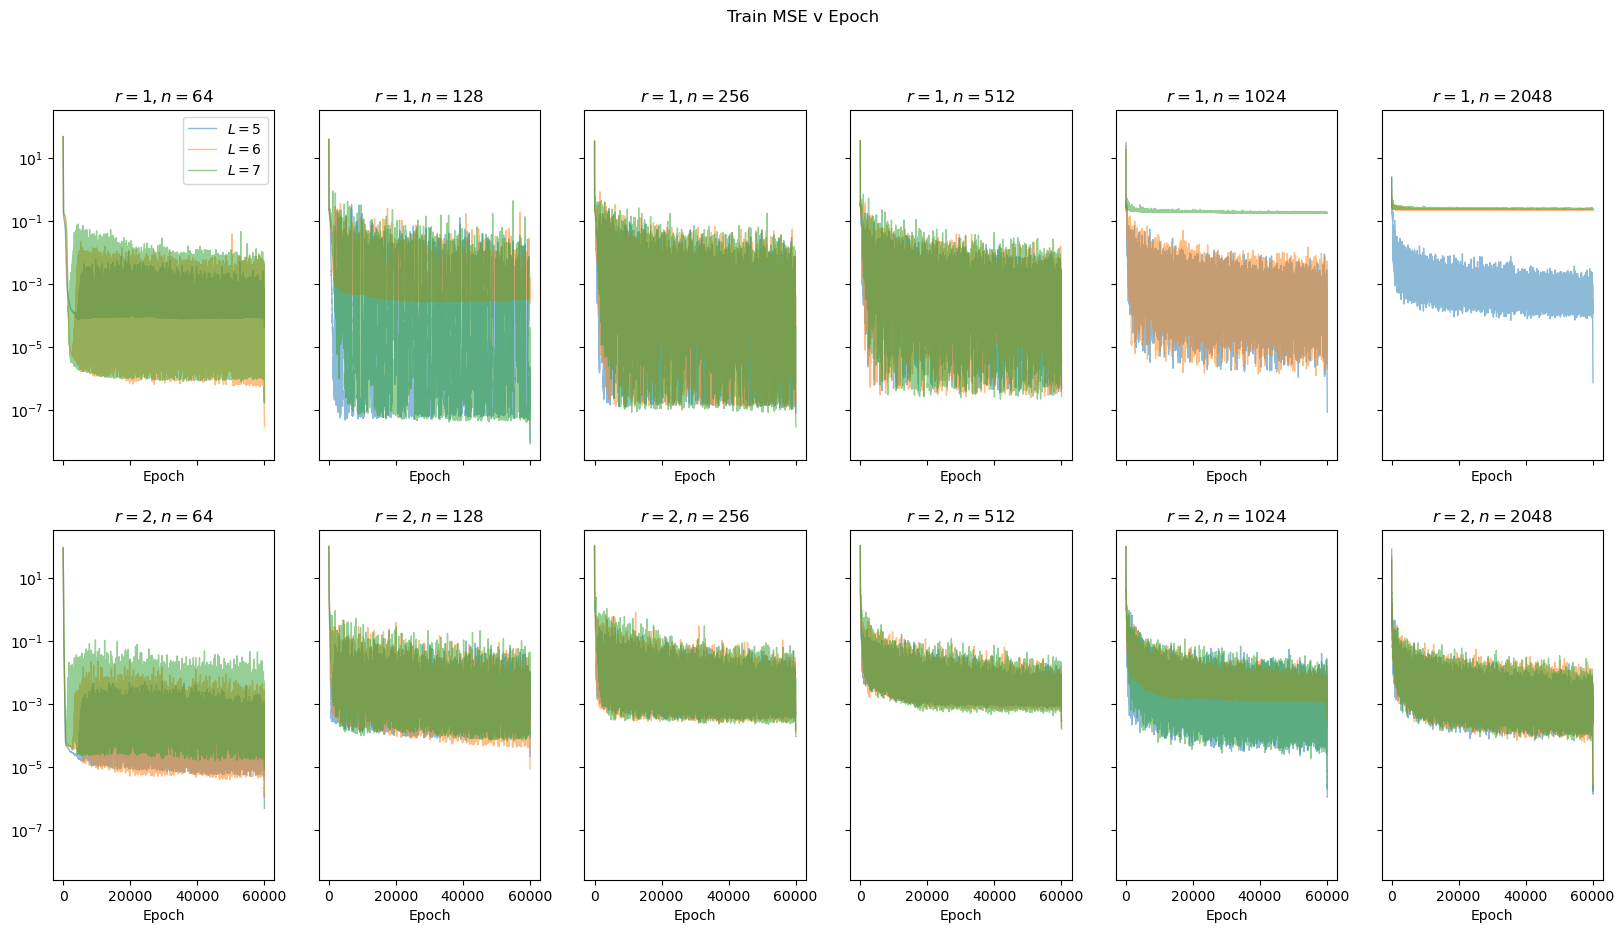

<Figure size 1000x1000 with 0 Axes>

In [48]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if 4 < row["L"] <= 7:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse567.png",dpi=300)
plt.show()

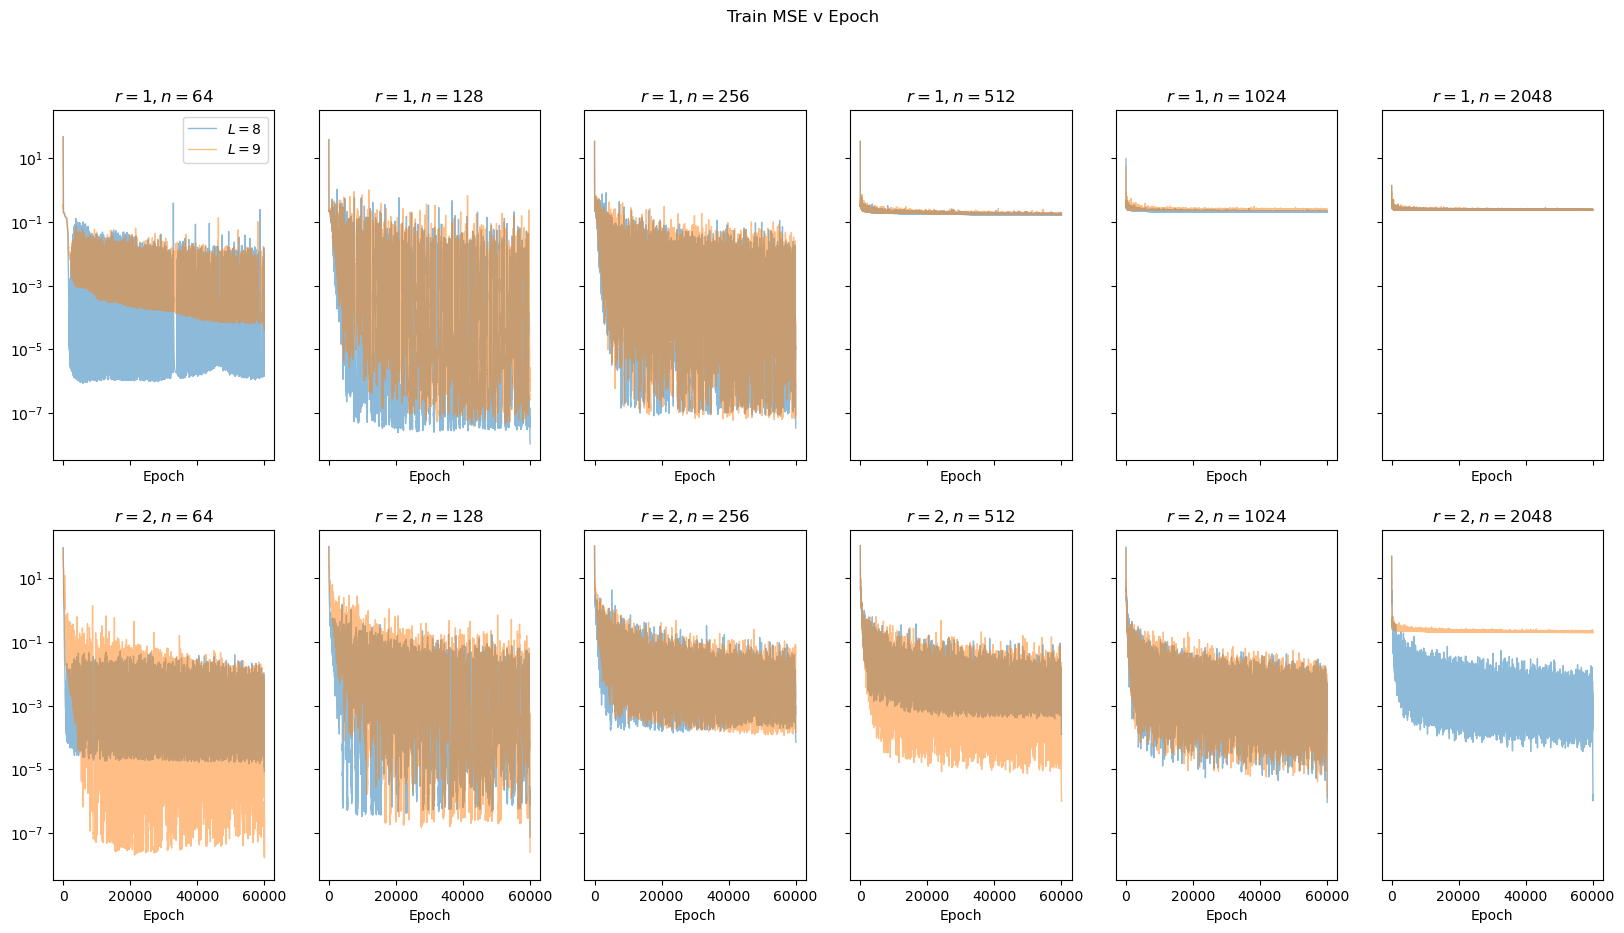

<Figure size 1000x1000 with 0 Axes>

In [49]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if row["L"] > 7:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse8910.png",dpi=300)
plt.show()

## Weight Decay v Epoch

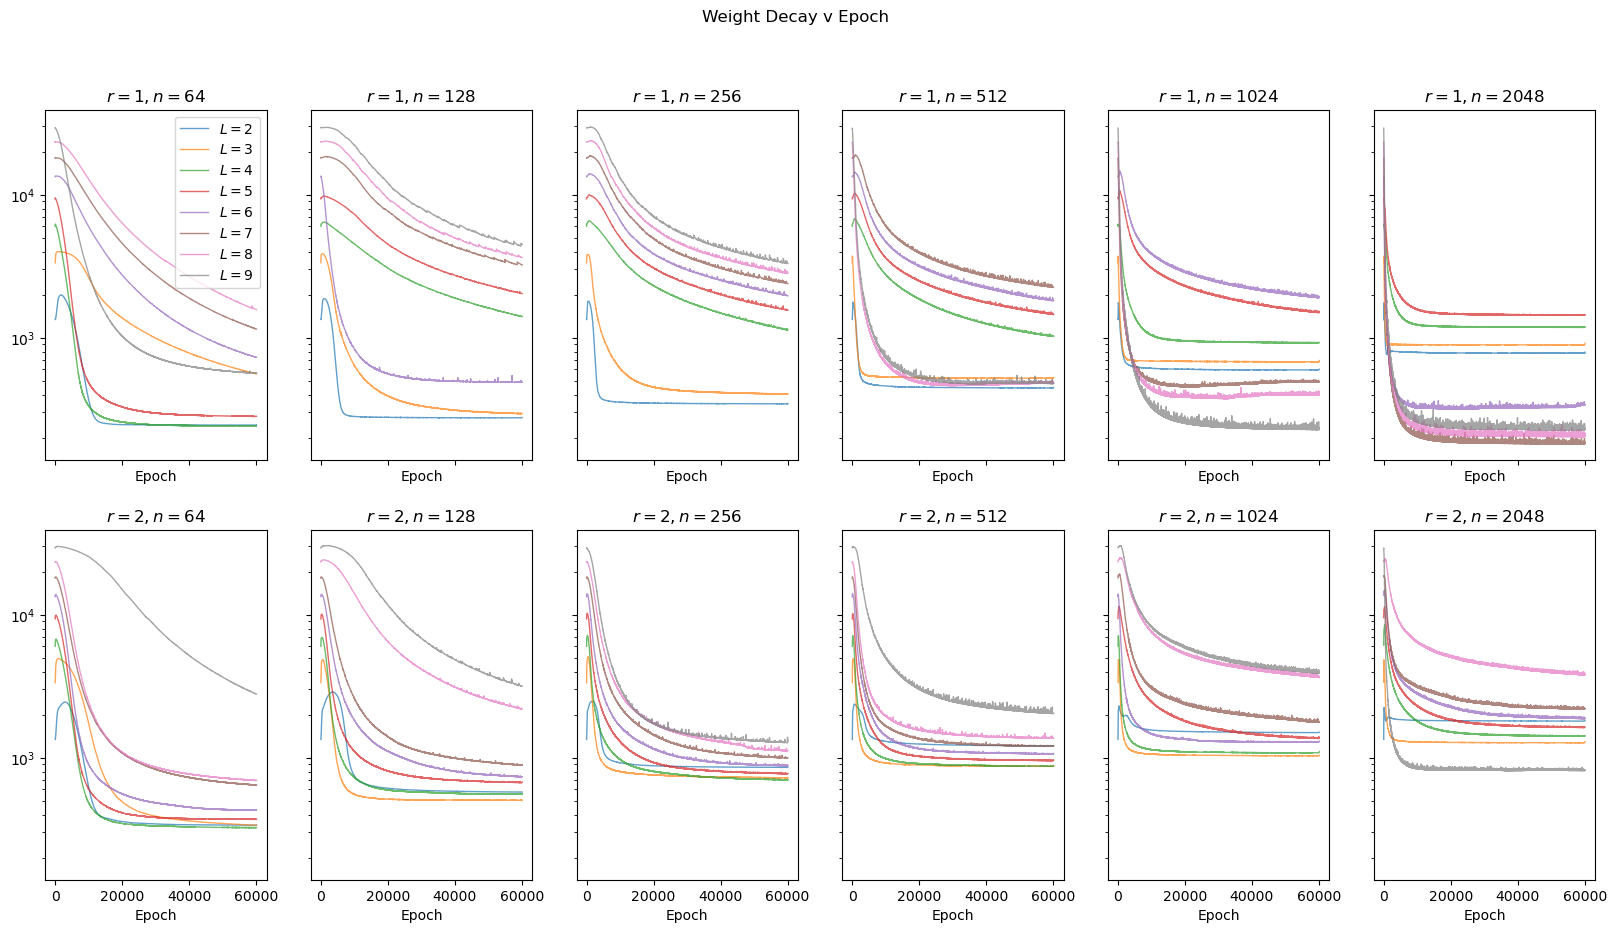

<Figure size 1000x1000 with 0 Axes>

In [50]:
f, ax = plt.subplots(len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    ax[whichrow,whichcol].semilogy(row["Weight Decay"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Weight Decay v Epoch")
f.savefig(job_name+"/weightdecay.png",dpi=300)
plt.show()

## learning rates

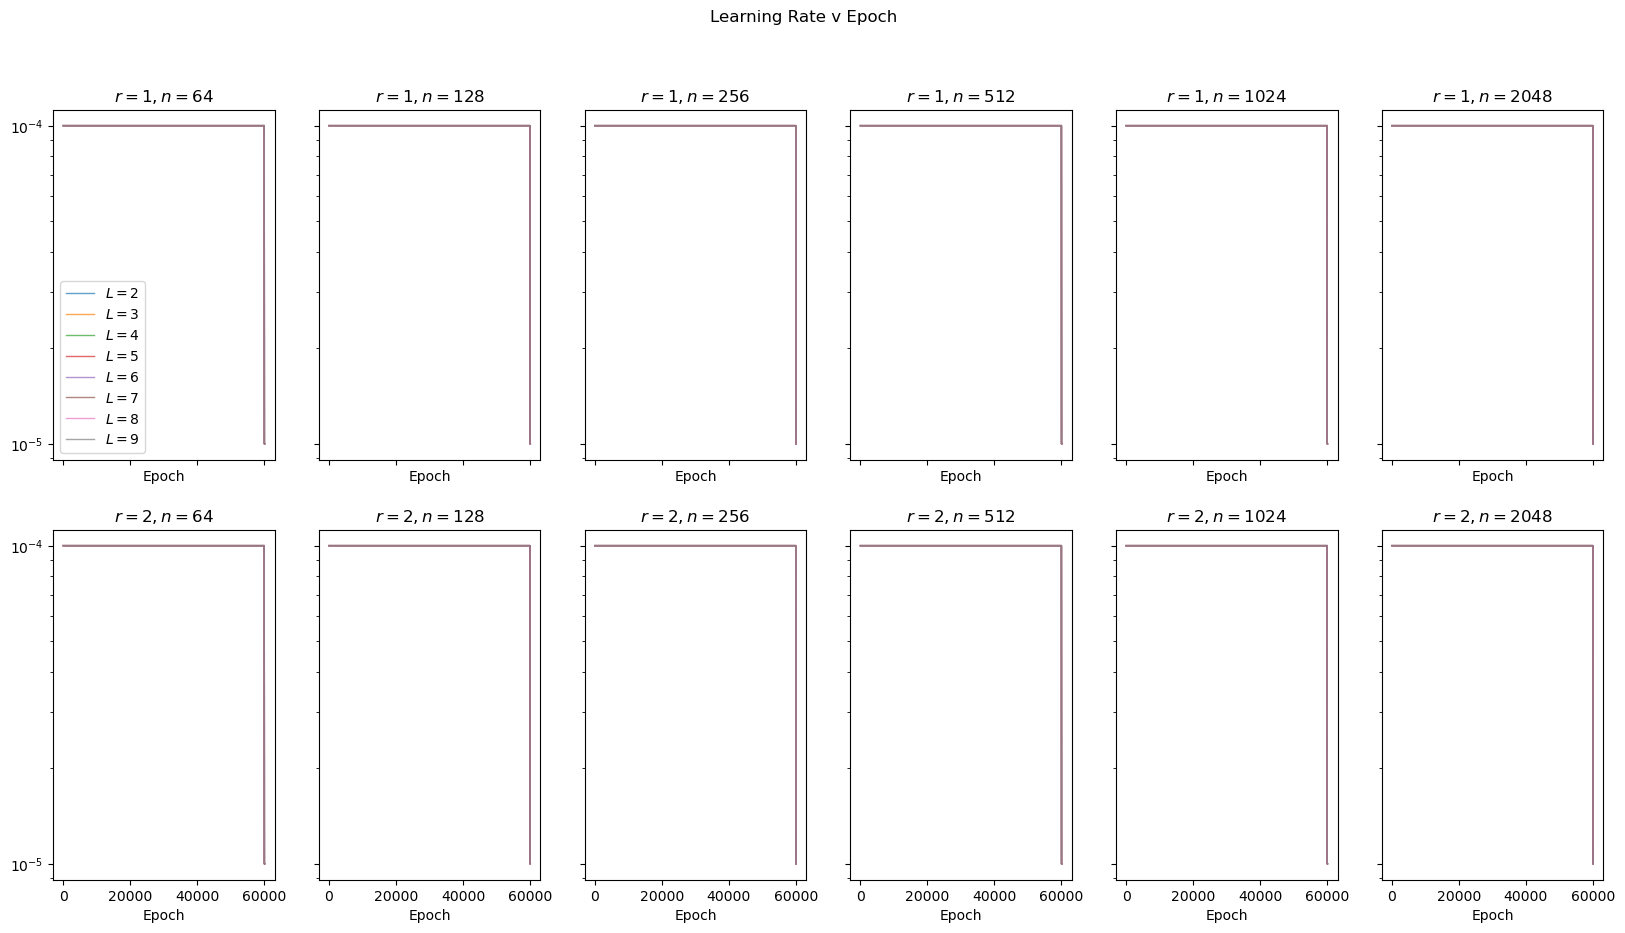

<Figure size 1000x1000 with 0 Axes>

In [51]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    ax[whichrow,whichcol].semilogy(row["Learning Rate"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Learning Rate v Epoch")
f.savefig(job_name+"/LearningRate.png",dpi=300)
plt.show()